# Use of BERTopic

See code and documentation here https://github.com/MaartenGr/BERTopic https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.fit_transform

```fit_transform``` using as input docs and embeddings returned error on Mac

- BERTopic return only one topic per document

In [ ]:
#@title Connecting drive to ensure future codeblocks work
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install bertopic pip install matplotlib pip install langdetect pip install label-studio-sdk

In [ ]:
import json
import os
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from langdetect import detect, LangDetectException
import pickle
import pandas as pd
import numpy as np
from bertopic import BERTopic
from google.colab import files

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Define paths
json_file_path = '/content/drive/MyDrive/supervised_bert_topic_dir/lsSNAPshot.json'
list_dir = '/content/drive/MyDrive/supervised_bert_topic_dir/'

# Load JSON data
with open(json_file_path, 'r') as f:
    json_data = json.load(f)

# Extract text data, app names, and IDs from JSON
texts = []
app_names = []
ids = []
for task in json_data:
    if 'data' in task and 'text' in task['data'] and 'app_name' in task['data']:
        text = task['data']['text']
        app_name = task['data']['app_name']
        task_id = task['id']
        if len(text) > 100:  # Apply the text length filter
            texts.append(text)
            app_names.append(app_name)
            ids.append(task_id)

unprocessedTexts = list(texts)

# Function definitions
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = nltk.pos_tag(words)
    lemmatized_words = []

    for word, tag in tagged_words:
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized_word = wnl.lemmatize(word, pos=wordnet_pos)
        lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

stop_words = set(stopwords.words('english'))

def remove_stop_words(sentence):
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def preprocess(dcs):
    for id_d, d in enumerate(dcs):
        d = d.translate(str.maketrans('', '', string.punctuation))
        d = lemmatize_sentence(d.lower())
        d = remove_stop_words(d)
        dcs[id_d] = d
    return dcs

# Preprocess texts
docs = preprocess(texts)
print("Documents have been preprocessed.")
masterList = [unprocessedTexts, docs, app_names, ids]

# Save the Master List using pickle
with open(list_dir + 'masterList.pkl', 'wb') as f:
    pickle.dump(masterList, f)
    print("Master List saved")

# Load the BERTopic model
model_dir = '/content/drive/MyDrive/supervised_bert_topic_dir/'

print("Model Loaded")
with open(model_dir + '/supervised_bert_topic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

classes = ['Activation', 'Saliency', 'Autonomy', 'Usability', 'Deep Trust',
           'Currency', 'Completeness', 'Exactitude', 'Consistency', 'Relevance', 'Representational Trust',
           'Promptness', 'Actionability', 'Situational Trust']  # Labels ordered by groups

def berTopicDocInput(masterList):
    data_for_filtered_docs = []
    print("Scoring documents in Bertopic")
    for i in range(len(masterList[1])):
        original_doc = masterList[0][i]
        input_text = masterList[1][i]
        app_name = masterList[2][i]
        review_id = masterList[3][i]
        input_topics, input_probs = loaded_model.transform([input_text])

        # Map the predicted topics to their corresponding classes
        mappings = loaded_model.topic_mapper_.get_mappings()
        filtered_mappings = {key: value for key, value in mappings.items() if key < len(classes)}
        mappings = {value: classes[key] for key, value in filtered_mappings.items()}
        predicted_class = mappings.get(input_topics[0], 'Unknown')

        # Collect data for CSV
        if input_probs is not None:
            doc_data = {
                "Original Document": original_doc,
                "Processed Document": input_text,
                "App Name": app_name,
                "Review ID": review_id
            }
            for topic_num, prob in enumerate(input_probs[0]):
                class_name = mappings.get(topic_num, 'Unknown')
                doc_data[class_name] = prob

            # Detect language and filter non-English documents
            try:
                if len(original_doc) > 100 and detect(original_doc) == 'en':
                    if all(p <= 1.0 for p in input_probs[0]):  # Check if all probabilities are ≤ 1.0
                        median_prob = np.median(input_probs[0])
                        doc_data["Median Probability"] = median_prob
                        data_for_filtered_docs.append(doc_data)
            except LangDetectException:
                continue
    print("Creating dataframe for excel file")
    # Create DataFrame for filtered documents
    df_filtered_docs = pd.DataFrame(data_for_filtered_docs)

    # Drop duplicate rows based on the 'Original Document' column
    df_filtered_docs = df_filtered_docs.drop_duplicates(subset=["Original Document"])

    # Sort the DataFrame in ascending order of the median probability
    df_filtered_docs_sorted = df_filtered_docs.sort_values(by="Median Probability")

    # Export the DataFrame to an Excel file
    output_filename_filtered = 'filtered_documents_sorted.xlsx'
    df_filtered_docs_sorted.to_excel(output_filename_filtered, index=False)

    # Download the file
    print("Excel document downloading")
    files.download(output_filename_filtered)

# Run the function
berTopicDocInput(masterList)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Documents have been preprocessed.
Master List saved
Model Loaded
Scoring documents in Bertopic
Creating dataframe for excel file
Excel document downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title The following two blocks are for redundancy in the event of a collab timeout
import label_studio_sdk
from label_studio_sdk import Client
import pandas as pd
import numpy as np
from google.colab import files
import string
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from langdetect import detect, LangDetectException
from bertopic import BERTopic
import pickle
import json

# Load the BERTopic model & masterList
model_dir = '/content/drive/MyDrive/supervised_bert_topic_dir/'

print("Model Loaded")
with open(model_dir + '/supervised_bert_topic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


with open(model_dir + '/masterList.pkl', 'rb') as f:
  masterList = pickle.load(f)
print("Masterlist Loaded")


# Load the BERTopic model
model_dir = '/content/drive/MyDrive/supervised_bert_topic_dir/'

print("Model Loaded")
with open(model_dir + '/supervised_bert_topic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

classes = ['Activation', 'Saliency', 'Autonomy', 'Usability', 'Deep Trust',
           'Currency', 'Completeness', 'Exactitude', 'Consistency', 'Relevance', 'Representational Trust',
           'Promptness', 'Actionability', 'Situational Trust']  # Labels ordered by groups

def berTopicDocInput(masterList):
    data_for_filtered_docs = []
    print("Scoring documents in Bertopic")
    for i in range(len(masterList[1])):
        original_doc = masterList[0][i]
        input_text = masterList[1][i]
        app_name = masterList[2][i]
        input_topics, input_probs = loaded_model.transform([input_text])

        # Map the predicted topics to their corresponding classes
        mappings = loaded_model.topic_mapper_.get_mappings()
        filtered_mappings = {key: value for key, value in mappings.items() if key < len(classes)}
        mappings = {value: classes[key] for key, value in filtered_mappings.items()}
        predicted_class = mappings.get(input_topics[0], 'Unknown')

        # Collect data for CSV
        if input_probs is not None:
            doc_data = {"Original Document": original_doc, "Processed Document": input_text, "App Name": app_name}
            for topic_num, prob in enumerate(input_probs[0]):
                class_name = mappings.get(topic_num, 'Unknown')
                doc_data[class_name] = prob

            # Detect language and filter non-English documents
            try:
                if len(original_doc) > 100 and detect(original_doc) == 'en':
                    if all(p <= 1.0 for p in input_probs[0]):  # Check if all probabilities are ≤ 1.0
                        median_prob = np.median(input_probs[0])
                        doc_data["App Name"]= app_name
                        doc_data["Median Probability"] = median_prob
                        data_for_filtered_docs.append(doc_data)
            except LangDetectException:
                continue
    print("Creating dataframe for excel file")
    # Create DataFrame for filtered documents
    df_filtered_docs = pd.DataFrame(data_for_filtered_docs)

    # Drop duplicate rows based on the 'Original Document' column
    df_filtered_docs = df_filtered_docs.drop_duplicates(subset=["Original Document"])

    # Sort the DataFrame in ascending order of the median probability
    df_filtered_docs_sorted = df_filtered_docs.sort_values(by="Median Probability")

    # Export the DataFrame to an Excel file
    output_filename_filtered = 'filtered_documents_sorted.xlsx'
    df_filtered_docs_sorted.to_excel(output_filename_filtered, index=False)

    # Download the file
    print("Excel document downloading")
    files.download(output_filename_filtered)

# Run the function
berTopicDocInput(masterList)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Model Loaded
Masterlist Loaded
Model Loaded
Scoring documents in Bertopic
Creating dataframe for excel file
Excel document downloading


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Create DataFrame for filtered documents
    df_filtered_docs = pd.DataFrame(data_for_filtered_docs)

    # Drop duplicate rows based on the 'Original Document' column
    df_filtered_docs = df_filtered_docs.drop_duplicates(subset=["Original Document"])

    # Sort the DataFrame in ascending order of the median probability
    df_filtered_docs_sorted = df_filtered_docs.sort_values(by="Median Probability")

    # Export the DataFrame to an Excel file
    output_filename_filtered = 'filtered_documents_sorted.xlsx'
    df_filtered_docs_sorted.to_excel(output_filename_filtered, index=False)

    # Download the file
    files.download(output_filename_filtered)

IndentationError: unexpected indent (<ipython-input-1-5cbeff185e97>, line 2)

## Here I need your help

import in one of the first blocks, the libraries for doing k-Fold cross validation. Here split the dataset so to have

Learning (80% of the data), Test (20%)
5-Fold CV and iterate.

It is important to **stratify**. This means that the proportion of data for each class is preserved across splits.

In [ ]:
# from bertopic import BERTopic
import json
import random
import string
import nltk
import pickle
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import pandas as pd
import itertools
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')



from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction

from bertopic import BERTopic

from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import csv
import requests

# Replace these with your actual API key and project ID
API_KEY = 'Obfuscated'
PROJECT_ID = 'Obfuscated'
BASE_URL = 'https://app.heartex.com'

# Setting up the headers for your request
headers = {
    'Authorization': f'Token {API_KEY}'
}

# The endpoint URL for fetching tasks with annotations
url = f'{BASE_URL}/api/projects/{PROJECT_ID}/export?exportType=JSON'

# Make the request to get your data
response = requests.get(url, headers=headers)

# Initialize two empty lists: one for texts, another for labels
texts = []
labels_list = []
classes = ['Activation', 'Saliency', 'Autonomy', 'Usability', 'Deep Trust',
           'Currency', 'Completeness', 'Exactitude', 'Consistency', 'Relevance', 'Representational Trust',
           'Promptness', 'Actionability', 'Situational Trust']  # Labels ordered by groups

if response.status_code == 200:
    annotations_data = response.json()

    for annotation in annotations_data:
        text = annotation['data']['text']
        labels = []
        #for ann in annotation['annotations']:
            #for result in ann['result']:
                #labels.extend(result['value']['labels'])
        #labels = list(set(labels))
        labels = classes
        # Append text to the texts list and its corresponding label to the labels_list for each label
        for label in labels:
            if label.strip():  # Skip empty or whitespace-only labels
                texts.append(text)
                labels_list.append(label)
else:
    print("Failed to fetch data:", response.status_code, response.text)
unprocessedTexts=list(texts)


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = nltk.pos_tag(words)
    lemmatized_words = []

    for word, tag in tagged_words:
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized_word = wnl.lemmatize(word, pos=wordnet_pos)
        lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

stop_words = set(stopwords.words('english'))
# Define a function to remove stop words from a sentence
def remove_stop_words(sentence):
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def preprocess(dcs):
  for id_d, d in enumerate(dcs):
    d = d.translate(str.maketrans('', '', string.punctuation))
    d = lemmatize_sentence(d.lower())
    d = remove_stop_words(d)
    dcs[id_d] = d
  return dcs
docs = preprocess(texts)
print(docs)
textual_labels=labels_list
print(textual_labels)
textual_labels = np.array(textual_labels)
classes = np.unique(textual_labels)
numerical_labels = 100 * np.ones(len(textual_labels), dtype=int)
for id_c, c in enumerate(classes):
  idxs = textual_labels == c
  numerical_labels[idxs] = id_c

np.sum(numerical_labels == 4)
# you can check here if the labels are assigned correctly.
# You do not want any label with value 100 in this array
samples_per_class = []
for id_c, c in enumerate(classes):
  samples_per_class.append(np.sum(numerical_labels == id_c))

pd.DataFrame(index=classes, data=samples_per_class, columns=['#samples per class'])
target_names = list(classes)
masterList=[unprocessedTexts,docs]

import pandas as pd
from google.colab import files
from langdetect import detect, LangDetectException
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
from bertopic import BERTopic
#from bertopic.representation import BaseEmbedder, BaseDimensionalityReduction, BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer

# Initialize lists to store the filtered documents with average probability and CSV data
data_for_filtered_docs = []
data_for_csv = []
confMatList=[]
# Your data and classes setup here
docs_array = np.array(docs)
labels_array = np.array(numerical_labels)
splitCount = 5
ngram = (1, 2)

skf = StratifiedKFold(n_splits=splitCount, random_state=42, shuffle=True)

all_test_indices = []
all_probs = []

for train_index, test_index in skf.split(docs_array, labels_array):
    X_train, X_test = docs_array[train_index], docs_array[test_index]
    y_train, y_test = labels_array[train_index], labels_array[test_index]

    topic_model = BERTopic(
        n_gram_range=ngram,
        umap_model=BaseDimensionalityReduction(),
        hdbscan_model=BaseCluster(),
        ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True),
        calculate_probabilities=True
    )

    # Fit and transform the training data
    topics, probs = topic_model.fit_transform(X_train, y=y_train)

    mappings = topic_model.topic_mapper_.get_mappings()

    # Filter mappings to include only those keys that are within the range of class indices
    filtered_mappings = {key: value for key, value in mappings.items() if key < len(classes)}
    # Create mappings using only the filtered keys and corresponding class names
    mappings = {value: classes[key] for key, value in filtered_mappings.items()}

    df = topic_model.get_topic_info()
    df["Class"] = df.Topic.map(mappings)

    # Transform the test data
    pred_topics, probs = topic_model.transform(X_test)

    inv_mappings = {val: key for key, val in mappings.items()}
    pred_topics_text = [mappings.get(pred, 'Unknown') for pred in pred_topics]
    ground_truth_topics_text = [classes[y_] for y_ in y_test]

    # For loop to calculate probabilities and collect data for CSV
    if probs is not None:
        for i, doc in enumerate(X_test):
            doc_data = {"Document": doc}
            for topic_num, prob in enumerate(probs[i]):
                class_name = mappings.get(topic_num, 'Unknown')
                doc_data[class_name] = prob
            data_for_csv.append(doc_data)

     # Calculate confusion matrix for the current fold

    confusion = confusion_matrix(ground_truth_topics_text, pred_topics_text, labels=classes)
    confMatList.append(confusion)

    # Store test indices and probabilities for later processing
    all_test_indices.extend(test_index)
    all_probs.extend(probs)

# Define the directory and file path to save the model in your Google Drive
model_dir = '/content/drive/MyDrive/supervised_bert_topic_dir/'
# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the BERTopic model using pickle
with open(model_dir + 'supervised_bert_topic_model.pkl', 'wb') as f:
    pickle.dump(topic_model, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#@title Code to load model for testing purposes
# Assuming `loaded_model` contains the loaded BERTopic model
import pickle

# Load the trained BERTopic model
with open(model_dir + '/supervised_bert_topic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Transform the input document into topics and probabilities
def berTopicDocInput(input):
  input_topics, input_probs = loaded_model.transform([input_text])

  # Map the predicted topics to their corresponding classes
  mappings = loaded_model.topic_mapper_.get_mappings()
  filtered_mappings = {key: value for key, value in mappings.items() if key < len(classes)}
  mappings = {value: classes[key] for key, value in filtered_mappings.items()}
  predicted_class = mappings.get(input_topics[0], 'Unknown')

  print(f"{input} belongs to class: {predicted_class}")


# Preprocess the input document (replace 'input_text' with your actual input)
input_text = "Your input text goes here"
# Preprocess the input text as necessary

#Run thru berTopicDocInput as needed.

berTopicDocInput(input_text)

Your input text goes here belongs to class: Situational Trust


In [ ]:
#@title Data Generation
from google.colab import files

if all_probs:
    for i, index in enumerate(all_test_indices):
        doc_probs = all_probs[i]
        original_doc = masterList[0][index]
        processed_doc = masterList[1][index]  # X_test[i] could be used but using masterList for consistency

        # Detect language and filter non-English documents
        try:
            if len(original_doc) > 100 and detect(original_doc) == 'en':
                if all(p <= 0.4 for p in doc_probs):  # Check if all probabilities are ≤ 0.3
                    median_prob = np.median(doc_probs)

                    # Append to your data_for_filtered_docs list with median probability
                    data_for_filtered_docs.append({
                        "Original Document": original_doc,
                        "Processed Document": processed_doc,
                        "Median Probability": median_prob
                    })
        except LangDetectException:
            continue

# Create a DataFrame from the filtered documents
df_filtered_docs = pd.DataFrame(data_for_filtered_docs)

# Drop duplicate rows based on the 'Original Document' column
df_filtered_docs = df_filtered_docs.drop_duplicates(subset=["Original Document"])

# Sort the DataFrame in ascending order of the median probability
df_filtered_docs_sorted = df_filtered_docs.sort_values(by="Median Probability")

# Export the DataFrame to an Excel file
output_filename = 'filtered_documents_sorted.xlsx'
df_filtered_docs_sorted.to_excel(output_filename, index=False)

# Download the file
files.download(output_filename)

# Define a function to calculate correlation matrix for specific group of labels
def calculate_correlation_matrix(group_labels, title):
    # Check if all labels in the group are present in the DataFrame
    missing_labels = [label for label in group_labels if label not in df.columns]
    if missing_labels:
        print(f"Skipping labels: {missing_labels}. They are not present in the dataset.")
        group_labels = [label for label in group_labels if label not in missing_labels]

    # Filter the DataFrame to include only data for group of labels
    group_df = df[group_labels].dropna(axis=1, how='all')

    if len(group_df.columns) < 2:
        print("Insufficient labels to calculate correlation matrix.")
        return

    # Calculate correlation matrix
    corr_matrix = group_df.corr()

    # Visualize the lower triangular part of the correlation matrix as a heatmap with numbers
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

    mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=0)  # k=-1 to exclude the diagonal
    corr_matrix_lower = corr_matrix.where(mask)

    # Displaying only the lower half (excluding diagonal) with text annotations
    for i in range(len(corr_matrix)):
      for j in range(i + 1):  # Adjust loop to ensure diagonal values are included
        plt.text(j, i, f"{corr_matrix_lower.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    plt.imshow(corr_matrix_lower, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Correlation')
    plt.tight_layout()
    plt.show()


group_1_labels = ['Activation', 'Saliency', 'Autonomy', 'Usability', 'Deep Trust']
group_2_labels = ['Currency', 'Completeness', 'Exactitude', 'Consistency', 'Relevance', 'Representational Trust']
group_3_labels = ['Promptness', 'Actionability', 'Situational Trust']

# Calculate correlation matrices for each group of labels
calculate_correlation_matrix(group_1_labels, "Correlation Chart for Transparent Interaction")
calculate_correlation_matrix(group_2_labels, "Correlation Chart for Representational Fidelity")
calculate_correlation_matrix(group_3_labels, "Correlation Chart for Situational Awareness")

# Calculate balanced accuracy scores and put them into a DataFrame
scoreFrame = pd.DataFrame({
    'Balanced Accuracy Score': [np.mean([confMatList[i][j, j] / np.sum(confMatList[i][j, :]) for j in range(len(confMatList[i]))]) for i in range(len(confMatList))],
})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Skipping labels: ['Activation', 'Saliency', 'Autonomy', 'Usability', 'Deep Trust']. They are not present in the dataset.
Insufficient labels to calculate correlation matrix.
Skipping labels: ['Currency', 'Completeness', 'Exactitude', 'Consistency', 'Relevance', 'Representational Trust']. They are not present in the dataset.
Insufficient labels to calculate correlation matrix.
Skipping labels: ['Promptness', 'Actionability', 'Situational Trust']. They are not present in the dataset.
Insufficient labels to calculate correlation matrix.


n x n Confusion Matrix

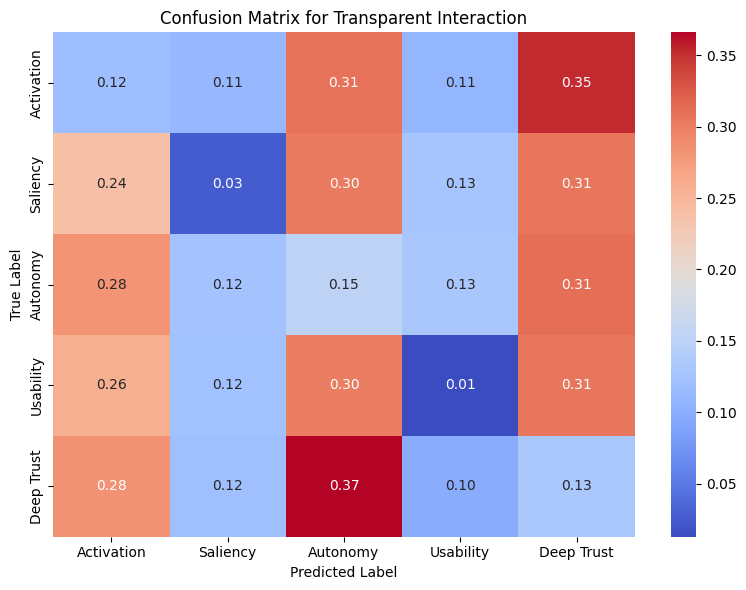

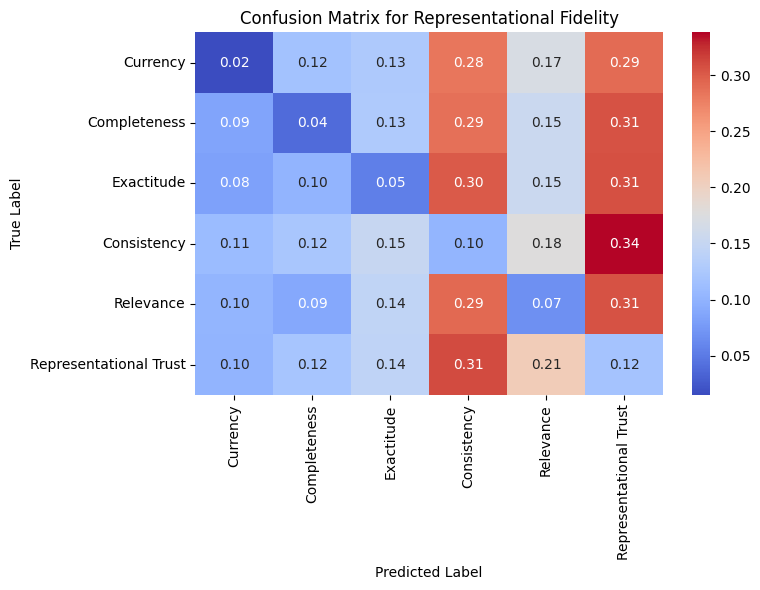

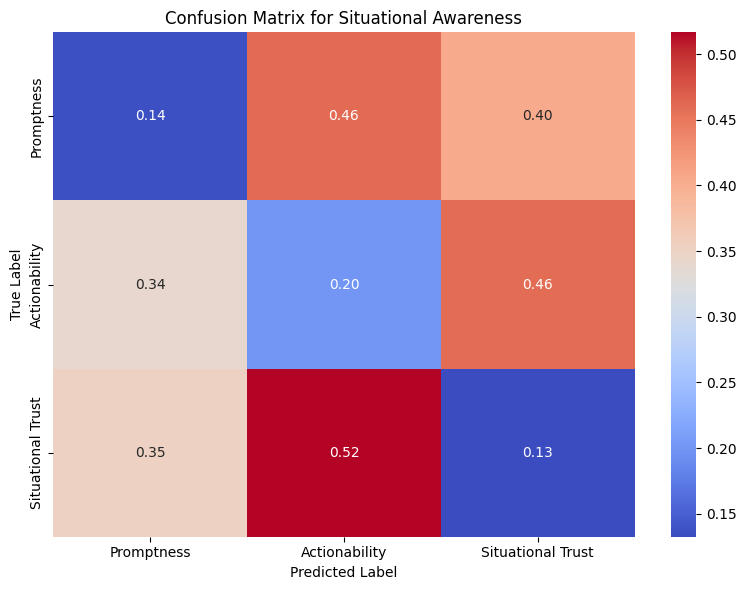

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the groups of labels
grouped_subdimensions = [
    ['Activation', 'Saliency', 'Autonomy', 'Usability', 'Deep Trust'],
    ['Currency', 'Completeness', 'Exactitude', 'Consistency', 'Relevance', 'Representational Trust'],
    ['Promptness', 'Actionability', 'Situational Trust']
]

# Convert classes to a list so the index can be accessed
if isinstance(classes, np.ndarray):
    classes = classes.tolist()

# Display confusion matrices for each dimension
for i, group_labels in enumerate(grouped_subdimensions):
    group_indices = [classes.index(label) for label in group_labels]
    group_conf_matrices = [confMatList[j][group_indices][:, group_indices] for j in range(len(confMatList))]

    # Takes the average confusion matrix to aggregate the results from different folds of cross-validation
    avg_conf_matrix = np.mean(group_conf_matrices, axis=0)

    group_titles = [
        "Confusion Matrix for Transparent Interaction",
        "Confusion Matrix for Representational Fidelity",
        "Confusion Matrix for Situational Awareness"
    ]

    # Normalize confusion matrix to percentages
    cmn = avg_conf_matrix.astype('float') / avg_conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix with Seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=group_labels, yticklabels=group_labels, cmap='coolwarm')
    plt.title(group_titles[i])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

Confusion Matrix 2x2

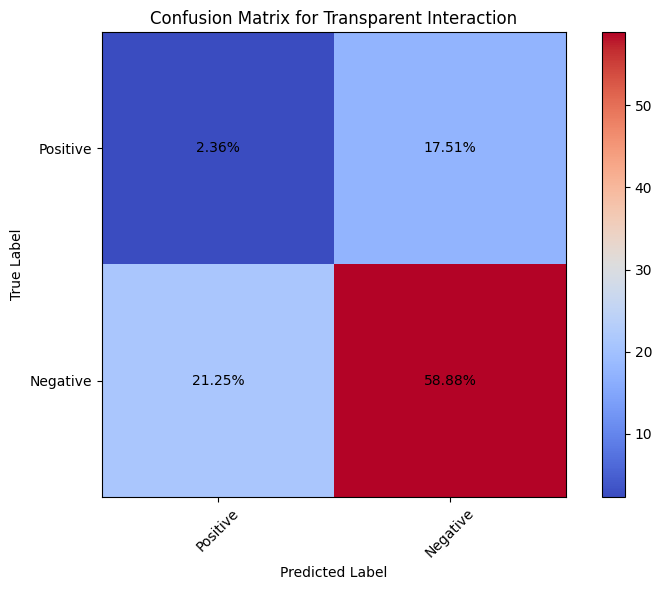

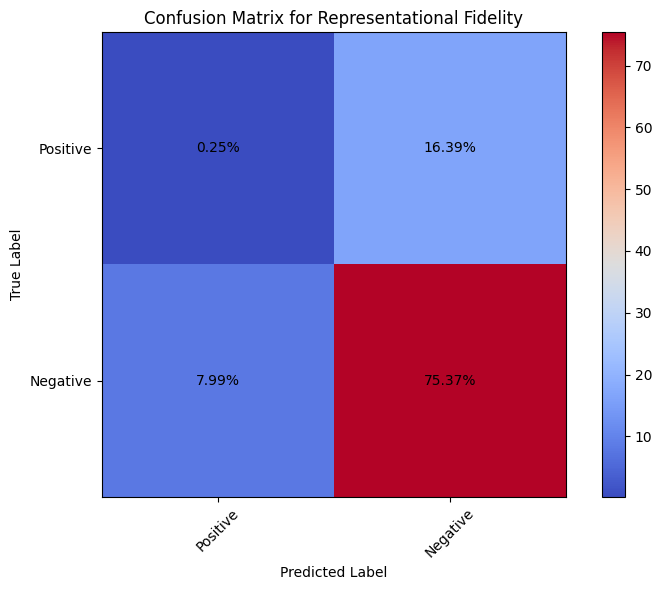

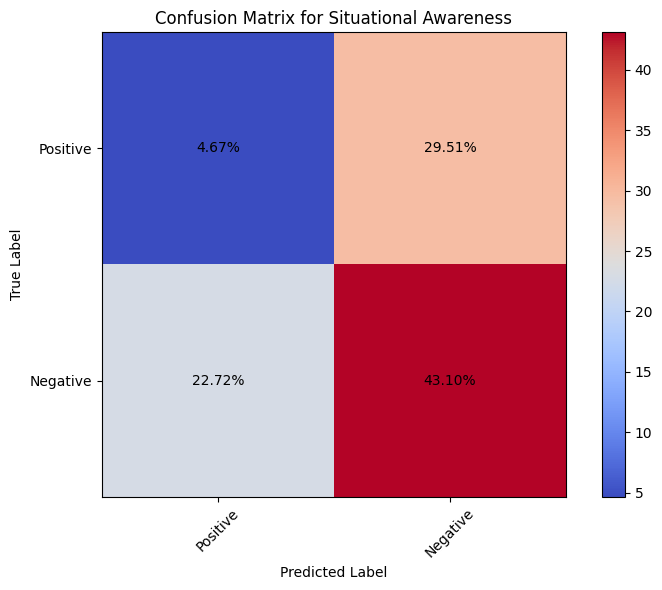

In [ ]:
# Define a function to convert a confusion matrix to a 2x2 matrix of percentages
def convert_to_2x2_percentage(conf_matrix):
    # True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
    TP = conf_matrix[0, 0]
    FP = conf_matrix[0, 1:].sum()
    FN = conf_matrix[1:, 0].sum()
    TN = conf_matrix[1:, 1:].sum()

    # Calculate percentages
    total = TP + FP + FN + TN
    TP_percent = (TP / total) * 100
    FP_percent = (FP / total) * 100
    FN_percent = (FN / total) * 100
    TN_percent = (TN / total) * 100

    return np.array([[TP_percent, FP_percent], [FN_percent, TN_percent]])

# Display confusion matrices for each dimension
for i, group_labels in enumerate(grouped_subdimensions):
    group_indices = [classes.index(label) for label in group_labels]
    group_conf_matrices = [confMatList[j][group_indices][:, group_indices] for j in range(len(confMatList))]

    # Takes the average confusion matrix to aggregate the results from different folds of cross-validation
    avg_conf_matrix = np.mean(group_conf_matrices, axis=0)

    # Convert confusion matrix to 2x2 matrix of percentages
    avg_conf_matrix_2x2_percentage = convert_to_2x2_percentage(avg_conf_matrix)

    group_titles = [
        "Confusion Matrix for Transparent Interaction",
        "Confusion Matrix for Representational Fidelity",
        "Confusion Matrix for Situational Awareness"
    ]

    # Plot the confusion matrix with labels
    plt.figure(figsize=(8, 6))
    plt.imshow(avg_conf_matrix_2x2_percentage, cmap='coolwarm', interpolation='nearest')
    plt.title(group_titles[i])
    plt.colorbar()
    plt.xticks(np.arange(2), ['Positive', 'Negative'], rotation=45)
    plt.yticks(np.arange(2), ['Positive', 'Negative'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations with percentage values
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{avg_conf_matrix_2x2_percentage[i, j]:.2f}%', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [ ]:
print(scoreFrame)
for idx, matrix in enumerate(confMatList):
  print(f"#+{idx}")
  print(pd.DataFrame(matrix, columns=classes, index=classes))
  print("-" * 30)  # Separating each matrix with dashes for clarity

   Balanced Accuracy Score
0                 0.027113
1                 0.024035
2                 0.029863
3                 0.027808
4                 0.028133
#+0
                        Actionability  Activation  Autonomy  Completeness  \
Actionability                       3           4        59            12   
Activation                          4           0        55            11   
Autonomy                            5           4        32            13   
Completeness                        5           1        55             5   
Consistency                         5           4        60            13   
Currency                            5           4        69            13   
Deep Trust                          6           2        74            11   
Exactitude                          6           8        61            12   
Promptness                          4           6        59            12   
Relevance                           1           7        54     